In [2]:
import pandas as pd
import re
import warnings
from sql_metadata import Parser
from matplotlib import pyplot as plt
import json
import logging

import sqlite3
from tqdm import tqdm
from itertools import product
from collections import defaultdict
import random
from datetime import datetime
import os
from math import ceil
import random
import sys
from datasets import load_dataset



warnings.filterwarnings('ignore')

In [ ]:
ls ../input/_dataset_v2

### Helper variables Functions

In [4]:
query_keywords_list = [
    "TOP","EXISTS","INTERSECT","SELECT","DISTINCT","RANK","AS",
    "WHERE","AND","OR","BETWEEN","LIKE","COUNT","SUM","AVG",
    "MIN","MAX","GROUP BY","ORDER BY","DESC","OFFSET","FETCH",
    "INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION",
    "HAVING","JOIN"
]
aggregate_keywords = ["COUNT","SUM","AVG","MIN","MAX","TOP"]
rank_keywords = ["RANK"]
fillter_keywords = ["GROUP BY","ORDER BY","FILTER","HAVING","EXISTS"]
join_keywords = [
    "JOIN","INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION","INTERSECT"
]
orderby_keywords = ["ORDER BY"]
groupby_keywords = ["GROUP BY"]
where_keywords =["WHERE"]
date_keywords =[
    "NOW","GETDATE","CURRENT_TIMESTAMP","DATEDIFF","DATEADD","YEAR","DAY","MONTH"
]
keyword_pattern = re.compile(r'\b(?:' + '|'.join(query_keywords_list) + r')\b', re.IGNORECASE)

def calculate_classification_new(df):
    ## Create new 3 columns 
    df["Expected count"] = df.index
    df["Expected difficulty"] = df.index
    df["Expected classification_new"] = df.index
    for index, row in df.iterrows():
        sql = row["Expected Query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in orderby_keywords:
                    classification = "ORDER BY"
                elif keyword in groupby_keywords:
                    classification = "GROUP BY"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE/RATIO"
                elif keyword in join_keywords:
                    classification = "JOIN"
                elif keyword in where_keywords:
                    classification = "WHERE"
                elif keyword in date_keywords:
                    classification = "DATE"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Expected difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Expected difficulty'] ="moderate"
        else:
            df.at[index,'Expected difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Expected classification_new'] = classification
        df.at[index,'Expected count'] =count


    ## Create new 3 columns 
    df["Predicted count"] = df.index
    df["Predicted difficulty"] = df.index
    df["Predicted classification_new"] = df.index
    for index, row in df.iterrows():
        sql = row["Predicted Query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in orderby_keywords:
                    classification = "ORDER BY"
                elif keyword in groupby_keywords:
                    classification = "GROUP BY"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE/RATIO"
                elif keyword in join_keywords:
                    classification = "JOIN"
                elif keyword in where_keywords:
                    classification = "WHERE"
                elif keyword in date_keywords:
                    classification = "DATE"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Predicted difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Predicted difficulty'] ="moderate"
        else:
            df.at[index,'Predicted difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Predicted classification_new'] = classification
        df.at[index,'Predicted count'] =count
    return df

def calculate_classification(df):
    ## Create new 3 columns 
    df["Expected count"] = df.index
    df["Expected difficulty"] = df.index
    df["Expected classification"] = df.index
    for index, row in df.iterrows():
        sql = row["Expected Query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in rank_keywords:
                    classification = "RANK"
                elif keyword in fillter_keywords:
                    classification = "FILTER"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE"
                elif keyword in join_keywords:
                    classification = "JOIN"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Expected difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Expected difficulty'] ="moderate"
        else:
            df.at[index,'Expected difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Expected classification'] = classification
        df.at[index,'Expected count'] =count

        ## Create new 3 columns 
    df["Predicted count"] = df.index
    df["Predicted difficulty"] = df.index
    df["Predicted classification"] = df.index
    for index, row in df.iterrows():
        sql = row["Predicted Query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in rank_keywords:
                    classification = "RANK"
                elif keyword in fillter_keywords:
                    classification = "FILTER"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE"
                elif keyword in join_keywords:
                    classification = "JOIN"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Predicted difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Predicted difficulty'] ="moderate"
        else:
            df.at[index,'Predicted difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Predicted classification'] = classification
        df.at[index,'Predicted count'] =count
    return df






def create_db_and_table(db_name):
    # Connect to SQLite database (or create it if it doesn't exist)
    conn = sqlite3.connect(f"{db_name}.db")
    cursor = conn.cursor()
    
    # Create table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS contract (
            id TEXT ,
            supplier TEXT,
            services TEXT,
            effective_date TEXT,
            keywords TEXT,
            document_type TEXT,
            expiration_date TEXT,
            created_by TEXT,
            region TEXT,
            tcv REAL,
            term_type TEXT,
            title TEXT,
            keyword TEXT,
            status TEXT,
            functions TEXT,
            countries TEXT,
            regions TEXT
        )
    ''')
    
    # Commit changes and close connection
    conn.commit()
    conn.close()



def check_database_schema(db_path):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Fetch and print all table names in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print("Tables in the database:", tables)
    
    # Check for 'contract' table and print its schema
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='contract';")
    if cursor.fetchone():
        print("Table 'contract' exists. Schema:")
        cursor.execute("PRAGMA table_info('contract');")
        columns = cursor.fetchall()
        for column in columns:
            print(column)
    else:
        print("Table 'contract' does not exist in the database.")

    # Close the connection
    conn.close()


def isValidSQL(sql, db):
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    try:
        cursor.execute(sql)
    except:
        return False
    return True


def query_processing(row,expected_query_column,generated_query_column):
    g_str =''
    p_str=''
    
    if ';' not in row[expected_query_column]:
        g_str = row[expected_query_column]+" ;"
    else:
        g_str = row[expected_query_column]
    
    if ';' not in str(row[generated_query_column]):
        p_str = str(row[generated_query_column])+" ;"
    else:
        p_str = str(row[generated_query_column]).split(";")[0]
        
    p_str = p_str.replace("> =", ">=").replace("< =", "<=").replace("! =", "!=")
    
    g_str = g_str.replace('``` ',"").replace('`',"")
    p_str = p_str.replace('``` ',"").replace('`',"")
    g_str = g_str.replace('" ',"")
    p_str = p_str.replace('" ',"")
    p_str = p_str.replace('### Expected Output:   ',"").replace('`',"")
    p_str = p_str.replace('Note:',"")
    p_str = p_str.replace(' Ex',"")
    p_str = p_str.replace('Here is the',"")
    p_str = p_str.split("### Explanation:")[0]
    p_str = p_str.split("Explanation: ")[0]
    p_str = p_str.split(": Explanation:")[0]
    p_str = p_str.split("Explanation:")[0]
    
    p_str = p_str.replace('ILIKE',"LIKE")
    p_str = p_str.replace('ilike',"LIKE")
    
    if "### Response:" in p_str:
        p_str = p_str.split("### Response:")[1]
    p_str = p_str.replace("###","")
    
    
   
    p_str_val = p_str.split(": Answer:")
    if len(p_str_val) ==2:
        p_str = p_str_val[1]
    p_str_val = p_str.split(": Query:")
    if len(p_str_val) ==2:
        p_str = p_str_val[1]
    
    if "This query" in p_str:
         p_str = p_str.split("This query")[0]
    if "The query" in p_str:
         p_str = p_str.split("The query")[0]     
    if "The above query" in p_str:
         p_str = p_str.split("The above query")[0]
    if "planation:" in p_str:
         p_str = p_str.split("planation:")[0]
    if "This queries" in p_str:
         p_str = p_str.split("This queries")[0]
    if "noqa: E501" in p_str:
         p_str = p_str.split("noqa: E501")[0]
   


    p_str = p_str.split(": Result:")[0]
    p_str = p_str.split("INST ")[0]
    p_str = p_str.split(" INST")[0]
    p_str = p_str.split(" find ")[0]
    p_str = p_str.split(" INST)")[0]
    
    
    p_str = p_str.strip()
    g_str = g_str.strip()
    p_str = p_str.replace("#","")
    p_str = reformat_query(p_str)
    p_str = replace_cur_year(p_str)
    
    if "select" in p_str.lower():
        if ':' in p_str:
            p_str=p_str.replace(":","")
        if ';' not in p_str:
            p_str=p_str+' ;'
    return g_str, p_str


def get_category(query):
    query_keywords_list = ["TOP","EXISTS","INTERSECT","SELECT","DISTINCT","TOP","RANK","AS","WHERE","AND","OR","BETWEEN","LIKE","COUNT","SUM","AVG","MIN","MAX","GROUP BY","ORDER BY","DESC","OFFSET","FETCH","INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION","HAVING","JOIN"]
    aggregate_keywords = ["COUNT","SUM","AVG","MIN","MAX","TOP"]
    rank_keywords = ["RANK"]
    fillter_keywords = ["GROUP BY","ORDER BY","FILTER","HAVING","EXISTS"]
    join_keywords = ["JOIN","INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION","INTERSECT"]

    count =0
    orderby_keywords = ["ORDER BY"]
    groupby_keywords = ["GROUP BY"]
    where_keywords =["WHERE"]
    date_keywords =["NOW","GETDATE","CURRENT_TIMESTAMP","DATEDIFF","DATEADD","YEAR","DAY","MONTH"]
    for keyword in query_keywords_list:
        if isinstance(query,str) and keyword in query:
            count=count+1
            if keyword in orderby_keywords:
                classification = "ORDER BY"
            elif keyword in groupby_keywords:
                classification = "GROUP BY"
            elif keyword in aggregate_keywords:
                classification = "AGGREGATE/RATIO"
            elif keyword in join_keywords:
                classification = "JOIN"
            elif keyword in where_keywords:
                classification = "WHERE"
            elif keyword in date_keywords:
                classification = "DATE"
    if count < 6:
        classification="simple"
    elif count > 5 and count < 9:
        classification="moderate"
    else:
        classification ="challenging"
    if classification == '':
        classification = 'SELECT'
    return classification


def replace_cur_year(query: str) -> str:
    return re.sub(
        "YEAR\s*\(\s*CURDATE\s*\(\s*\)\s*\)\s*", "2020", query, flags=re.IGNORECASE
    )

def formaterAndCaller_sqlite(row,database_path,expected_query_column,generated_query_column):
    db = database_path
    g_str = row[expected_query_column]
    p_str =row[generated_query_column]
    
    ## For query correction:
    g_str_p1,p_str_p1 =query_processing(row,expected_query_column,generated_query_column)
    
    eval_score,e,r = eval_exec_match_sqlite(db,db,p_str, g_str)
    eval_score1 ,error,result = eval_exec_match_sqlite(db,db,p_str_p1, g_str_p1)
   
    return eval_score,eval_score1,error,result

def reformat_query(query: str) -> str:
    t_stars = ["t1.*", "t2.*", "t3.*", "T1.*", "T2.*", "T3.*"]
    for ts in t_stars:
        query = query.replace(ts, "*")
    return query


def error_handling(e):
    error ="None"
    if 'no such column' in e:
            error ="No such column"
    elif 'syntax error' in e:
            error = "Syntax error"
    elif 'no such table' in e:
            error = "No such table"
    elif 'ambiguous column name' in e:
            error = "Ambiguous column name"
    else:
        error = e
    return error
def eval_exec_match_sqlite(db, db2, p_str, g_str):
    """
    return 1 if the values between prediction and gold are matching
    in the corresponding index. Currently not support multiple col_unit(pairs).
    """
    print("p_str value---",p_str)
    
    error ='None'
    result = "error"
    print("Connecting to database at:", db2)
    conn = sqlite3.connect(db2)
    conn.text_factory = lambda b: b.decode(errors = 'ignore')
    cursor = conn.cursor()
    try:
        cursor.execute(p_str)
        p_res = cursor.fetchall()
    except Exception as e:
        print("SQL Error:", e)
        # import ipdb; ipdb.set_trace()
        error =error_handling(str(e))
        return False,error,result
    print("Connecting to database at:", db)
    conn = sqlite3.connect(db)
    conn.text_factory = lambda b: b.decode(errors = 'ignore')
    cursor = conn.cursor()
    try:
        cursor.execute(g_str)
    except Exception as e:
        error =error_handling(str(e))
        print("SQL Error:", e)
        return False,error,result
    q_res = cursor.fetchall()

    ##orders_matter = 'order by' in g_str.lower()
    orders_matter = False
    value,result = result_eq(p_res, q_res, order_matters=orders_matter)
    return value,error,result




def result_eq(result1, result2, order_matters):
    result ="None"
    if len(result1) == 0 and len(result2) == 0:
        result = "same"
        return True,result

    # if length is not the same, then they are definitely different bag of rows
    status =0
    if len(result1) != len(result2):
        if len(result1)==0:
            result = "P result zero"
        elif len(result2)==0:
            result = "Q result zero"
        elif len(result1) > len(result2):
            for res in result2:
                if res in result1:
                    status =1
            if status ==1:
                result = "Partial Match"
            else:
                result = "P result greater"
                
        elif len(result1) < len(result2):
            for res in result1:
                if res in result2:
                    status =1
            if status ==1:
                result = "Partial Match"
            else:   
                result = "Q result greater"    
        return False,result
        

    num_cols = len(result1[0])

    # if the results do not have the same number of columns, they are different
    if len(result2[0]) != num_cols:
        result = "column length different"
        return False,result

    # unorder each row and compare whether the denotation is the same
    # this can already find most pair of denotations that are different
    if not quick_rej(result1, result2, order_matters):
        count =0
        for res in result2:
                if res in result1:
                    count =1
        if count ==1:
            result = "Partial Match"
        else:
            result = "order or result different"
        return False,result

    # the rest of the problem is in fact more complicated than one might think
    # we want to find a permutation of column order and a permutation of row order,
    # s.t. result_1 is the same as result_2
    # we return true if we can find such column & row permutations
    # and false if we cannot
    tab1_sets_by_columns = [{row[i] for row in result1} for i in range(num_cols)]

    # on a high level, we enumerate all possible column permutations that might make result_1 == result_2
    # we decrease the size of the column permutation space by the function get_constraint_permutation
    # if one of the permutation make result_1, result_2 equivalent, then they are equivalent
    for perm in get_constraint_permutation(tab1_sets_by_columns, result2):
        if len(perm) != len(set(perm)):
            continue
        if num_cols == 1:
            result2_perm = result2
        else:
            result2_perm = [permute_tuple(element, perm) for element in result2]
        if order_matters:
            if result1 == result2_perm:
                result ="same"
                return True,result
        else:
            # in fact the first condition must hold if the second condition holds
            # but the first is way more efficient implementation-wise
            # and we use it to quickly reject impossible candidates
            if set(result1) == set(result2_perm) and multiset_eq(result1, result2_perm):
                result ="same"
                return True,result
    return False,result


def insert_data(db_name, data):
    # Connect to SQLite database
    conn = sqlite3.connect(f"{db_name}.db")
    cursor = conn.cursor()

def quick_rej(result1, result2, order_matters):
    s1 = [unorder_row(row) for row in result1]
    s2 = [unorder_row(row) for row in result2]
    if order_matters:
        return s1 == s2
    else:
        return set(s1) == set(s2)

def unorder_row(row):
    return tuple(sorted(row, key=lambda x: str(x) + str(type(x))))

def get_constraint_permutation(tab1_sets_by_columns, result2):
    num_cols = len(result2[0])
    perm_constraints = [{i for i in range(num_cols)} for _ in range(num_cols)]
    if num_cols <= 3:
        return product(*perm_constraints)

    # we sample 20 rows and constrain the space of permutations
    for _ in range(20):
        random_tab2_row = random.choice(result2)

        for tab1_col in range(num_cols):
            for tab2_col in set(perm_constraints[tab1_col]):
                if random_tab2_row[tab2_col] not in tab1_sets_by_columns[tab1_col]:
                    perm_constraints[tab1_col].remove(tab2_col)
    return product(*perm_constraints)

def permute_tuple(element, perm):
    assert len(element) == len(perm)
    return tuple([element[i] for i in perm])

def multiset_eq(l1, l2):
    if len(l1) != len(l2):
        return False
    d = defaultdict(int)
    for e in l1:
        d[e] = d[e] + 1
    for e in l2:
        d[e] = d[e] - 1
        if d[e] < 0:
            return False
    return True


db_name = 'contracts_database'
create_db_and_table(db_name)





with open("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/datasets/synthetic_data.json","r") as file:
    data = json.load(file)
    for obj in data:
        insert_data(db_name, obj)
import csv
with open("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/synthetic_data.csv", mode='w', newline='') as file:
    # Create a writer object from csv module
    csv_writer = csv.writer(file)
    
    # Add column headers
    csv_writer.writerow(data[0].keys())
    
    # Add rows
    for row in data:
        csv_writer.writerow(row.values())


def tokenize_sql_query(sql_query):
    token_list = []
    try:
        for token in Parser(sql_query).tokens:
            token_list.append(str(token.value))
    except:
        pass
    return token_list


dict_accuracy_overall = {}

In [5]:
 # evaluation_results_multi_shot_cot_synonyms_codellama_codellama-34b-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_ibm_granite-34b-code-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_deepseek-ai_deepseek-coder-33b-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_ibm_granite-13b-instruct-v2.csv
 # evaluation_results_multi_shot_cot_synonyms_ibm_granite-20b-code-instruct.csv #errors
 # evaluation_results_multi_shot_cot_synonyms_ibm_granite-8b-code-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_kaist-ai_prometheus-8x7b-v2.csv
 # evaluation_results_multi_shot_cot_synonyms_meta-llama_llama-3-70b-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_mistralai_mixtral-8x7b-instruct-v01.csv

# 1. codellama_34b_instruct

In [ ]:
df = pd.read_csv("../input/_dataset_v2/Answers_codellama_codellama-34b-instruct_exEvaluator.csv").rename(columns={"Answers_codellama_codellama-34b-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_codellama_codellama-34b-instruct"})#[["Question","Entity","Expected","Answers_codellama_codellama-34b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/codellama_34b_instruct.csv")
df

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/codellama_34b_instruct.csv",index=False)


df_codellama_34b_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/codellama_34b_instruct.csv")
dict_accuracy_overall["codellama_34b_instruct"] =  df_codellama_34b_instruct[df_codellama_34b_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 2. ibm_granite_34b_code_instruct

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/Answers_ibm_granite-34b-code-instruct_exEvaluator.csv").rename(columns={"Answers_ibm_granite-34b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-34b-code-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-34b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/ibm_granite_34b_code_instruct.csv")
df

In [ ]:
df.columns

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/ibm_granite_34b_code_instruct.csv",index=False)


df_ibm_granite_34b_code_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite_34b_code_instruct.csv")
dict_accuracy_overall["ibm_granite_34b_code_instruct"] =  df_ibm_granite_34b_code_instruct[df_ibm_granite_34b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 3. Deepseek_coder_33b_instruct_data

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/Answers_deepseek-ai_deepseek-coder-33b-instruct_exEvaluator.csv").rename(columns={"Answers_deepseek-ai_deepseek-coder-33b-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_deepseek-ai_deepseek-coder-33b-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-34b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/deepseek-ai_deepseek-coder-33b-instruct.csv")
df

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/Deepseek_coder_33b_instruct_data.csv",index=False)


df_Deepseek_coder_33b_instruct_data = pd.read_csv("../output/inference__v2/accumulated_accuracy/Deepseek_coder_33b_instruct_data.csv")
dict_accuracy_overall["Deepseek_coder_33b_instruct_data"] =  df_Deepseek_coder_33b_instruct_data[df_Deepseek_coder_33b_instruct_data["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 4. ibm_granite-13b-instruct-v2

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/Answers_ibm_granite-13b-instruct-v2_exEvaluator.csv",).rename(columns={"Answers_ibm_granite-13b-instruct-v2":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-13b-instruct-v2"})#[["Question","Entity","Expected","Answers_ibm_granite-13b-instruct-v2","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/ibm_granite-13b-instruct-v2.csv", index=False)
df

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-13b-instruct-v2.csv",index=False)

df_ibm_granite_13b_instruct_v2 = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-13b-instruct-v2.csv")
dict_accuracy_overall["ibm_granite-13b-instruct-v2"] =  df_ibm_granite_13b_instruct_v2[df_ibm_granite_13b_instruct_v2["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 5.ibm_granite-20b-code-instruct

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/Answers_ibm_granite-20b-code-instruct_exEvaluator.csv").rename(columns={"Answers_ibm_granite-20b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-20b-code-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-20b-code-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/ibm_granite-20b-code-instruct.csv")
df

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-20b-code-instruct.csv",index=False)


df_ibm_granite_20b_code_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-20b-code-instruct.csv")
dict_accuracy_overall["ibm_granite-20b-code-instruct"] =  df_ibm_granite_20b_code_instruct[df_ibm_granite_20b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 6. ibm_granite-8b-code-instruct

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/Answers_ibm_granite-8b-code-instruct_exEvaluator.csv").rename(columns={"Answers_ibm_granite-8b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-8b-code-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-8b-code-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/ibm_granite-8b-code-instruct.csv")
df

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-8b-code-instruct.csv",index=False)

df_ibm_granite_8b_code_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-8b-code-instruct.csv")
dict_accuracy_overall["ibm_granite-8b-code-instruct"] =  df_ibm_granite_8b_code_instruct[df_ibm_granite_8b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 7.kaist-ai_prometheus-8x7b-v2

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/Answers_kaist-ai_prometheus-8x7b-v2_exEvaluator.csv").rename(columns={"Answers_kaist-ai_prometheus-8x7b-v2":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_kaist-ai_prometheus-8x7b-v2"})#[["Question","Entity","Expected","Answers_ibm_granite-8b-code-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/kaist-ai_prometheus-8x7b-v2.csv")
df

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)

cat_df.to_csv("../output/inference__v2/accumulated_accuracy/kaist-ai_prometheus-8x7b-v2.csv",index=False)

df_kaist_ai_prometheus_8x7b_v2 = pd.read_csv("../output/inference__v2/accumulated_accuracy/kaist-ai_prometheus-8x7b-v2.csv")
dict_accuracy_overall["kaist-ai_prometheus-8x7b-v2"] =  df_kaist_ai_prometheus_8x7b_v2[df_kaist_ai_prometheus_8x7b_v2["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 8. meta-llama_llama-3-70b-instruct

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/Answers_meta-llama_llama-3-70b-instruct_exEvaluator.csv").rename(columns={"Answers_meta-llama_llama-3-70b-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_meta-llama_llama-3-70b-instruct"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/meta-llama_llama-3-70b-instruct.csv")
df

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/meta-llama_llama-3-70b-instruct.csv",index=False)
df_meta_llama_llama_3_70b_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/meta-llama_llama-3-70b-instruct.csv")
dict_accuracy_overall["meta-llama_llama-3-70b-instruct"] =  df_meta_llama_llama_3_70b_instruct[df_meta_llama_llama_3_70b_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 9.mistralai_mixtral-8x7b-instruct-v01

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/Answers_mistralai_mixtral-8x7b-instruct-v01_exEvaluator.csv").rename(columns={"Answers_mistralai_mixtral-8x7b-instruct-v01":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_mistralai_mixtral-8x7b-instruct-v01"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/mistralai_mixtral-8x7b-instruct-v01.csv")
df

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/mistralai_mixtral-8x7b-instruct-v01.csv",index=False)

In [ ]:
df_mistralai_mixtral_8x7b_instruct_v01 = pd.read_csv("../output/inference__v2/accumulated_accuracy/mistralai_mixtral-8x7b-instruct-v01.csv")
dict_accuracy_overall["mistralai_mixtral_8x7b_instruct_v01"] =  df_mistralai_mixtral_8x7b_instruct_v01[df_mistralai_mixtral_8x7b_instruct_v01["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 10. ibm_granite-34b-code-instruct_exEvaluator_agent

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/ibm_granite-34b-code-instruct_exEvaluator_agent.csv").rename(columns={"ibm_granite-34b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].astype(str).apply(tokenize_sql_query).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["Predicted Query"] = df["Predicted Query"].astype(str)
df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"ibm_granite-34b-code-instruct_exEvaluator_agent"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference__v2/ibm_granite-34b-code-instruct_exEvaluator_agent.csv")
df

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-34b-code-instruct_exEvaluator_agent.csv",index=False)

In [28]:
df_ibm_granite_34b_code_instruct_exEvaluator_agent = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-34b-code-instruct_exEvaluator_agent.csv")
dict_accuracy_overall["ibm_granite_34b_code_instruct_exEvaluator_agent"] =  df_ibm_granite_34b_code_instruct_exEvaluator_agent[df_ibm_granite_34b_code_instruct_exEvaluator_agent["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68,
 'ibm_granite-8b-code-instruct': 58.62,
 'kaist-ai_prometheus-8x7b-v2': 63.22,
 'meta-llama_llama-3-70b-instruct': 71.26,
 'mistralai_mixtral_8x7b_instruct_v01': 66.09,
 'ibm_granite_34b_code_instruct_exEvaluator_agent': 56.9}

# 11. code llama-7b

In [29]:
pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/_code_llama-7b_inference.csv").columns

Index(['Unnamed: 0', 'db_id', 'query', 'question', 'context', 'model_op'], dtype='object')

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/_code_llama-7b_inference.csv").rename(columns={"model_op":"Predicted Query","query":"Expected Query"}).drop(columns=["Unnamed: 0"])
df["predicted_query_toks"] = df["Predicted Query"].astype(str).apply(tokenize_sql_query).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["Predicted Query"] = df["Predicted Query"].astype(str)
df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"_code_llama_7b"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df

In [ ]:
check_database_schema("contracts_database.db")
df['expected_sql_valid'] = df['Expected Query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db"))
df['generated_sql_valid'] = df['Predicted Query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db"))
df['expected_sql_classification'] = df['Expected Query'].apply(lambda sql: get_category(sql))
df['generated_sql_classification'] = df['Predicted Query'].apply(lambda sql: get_category(sql))
results = []
for index, row in df.iterrows():
    evalScore, value, error, result = formaterAndCaller_sqlite(row, "contracts_database.db", "Expected Query", "Predicted Query")
    df.at[index, 'evalScore'] = evalScore
    df.at[index, 'evalScorePostProcessing'] = value
    df.at[index, 'error_type'] = error
    df.at[index, 'result'] = result
    results.append(evalScore)

df['evalScore'] = results
df.to_csv("../output/inference__v2/_code_llama_7b.csv",index=False)
EXAccuracy = sum(results) / len(results) if results else 0
logging.info(f"EX Accuracy for Predicted Query: {EXAccuracy}")

In [ ]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/_code_llama_7b.csv",index=False)

In [ ]:
df__code_llama_7b = pd.read_csv("../output/inference__v2/accumulated_accuracy/_code_llama_7b.csv")
dict_accuracy_overall["_code_llama_7b"] =  df__code_llama_7b[df__code_llama_7b["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

# 12. Granite-8b

In [ ]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/_dataset_v2/_granite_8b_inference.csv").rename(columns={"model_op":"Predicted Query","query":"Expected Query"}).drop(columns=["Unnamed: 0"])
df["predicted_query_toks"] = df["Predicted Query"].astype(str).apply(tokenize_sql_query).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["Predicted Query"] = df["Predicted Query"].astype(str)
df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"_granite_8b_inference"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df

In [ ]:
check_database_schema("contracts_database.db")
df['expected_sql_valid'] = df['Expected Query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db"))
df['generated_sql_valid'] = df['Predicted Query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db"))
df['expected_sql_classification'] = df['Expected Query'].apply(lambda sql: get_category(sql))
df['generated_sql_classification'] = df['Predicted Query'].apply(lambda sql: get_category(sql))
results = []
for index, row in df.iterrows():
    evalScore, value, error, result = formaterAndCaller_sqlite(row, "contracts_database.db", "Expected Query", "Predicted Query")
    df.at[index, 'evalScore'] = evalScore
    df.at[index, 'evalScorePostProcessing'] = value
    df.at[index, 'error_type'] = error
    df.at[index, 'result'] = result
    results.append(evalScore)

df['evalScore'] = results
df.to_csv("../output/inference__v2/_granite_8b_inference.csv",index=False)
EXAccuracy = sum(results) / len(results) if results else 0
logging.info(f"EX Accuracy for Predicted Query: {EXAccuracy}")

In [38]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference__v2/accumulated_accuracy/_granite_8b_inference.csv",index=False)

6 6 ##
['moderate', 6, 6, 1.0]
122 168 ##
['simple', 168, 122, 0.7261904761904762]


In [ ]:
df__granite_8b_inference = pd.read_csv("../output/inference__v2/accumulated_accuracy/_granite_8b_inference.csv")
dict_accuracy_overall["_granite_8b_inference"] =  df__granite_8b_inference[df__granite_8b_inference["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

Text(0.5, 1.0, 'Predicted SQL Query Token Length Frequency')

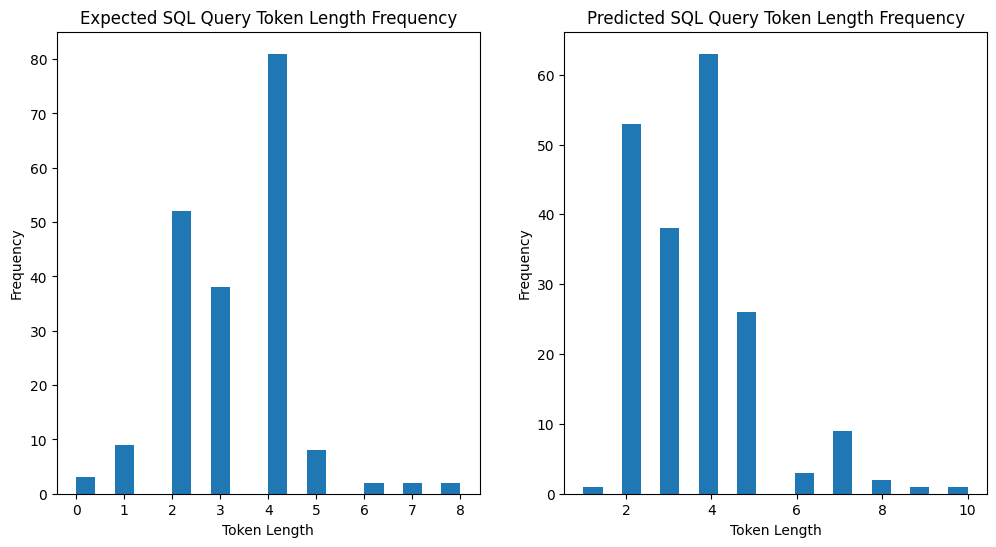

In [40]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
ax[0].hist(df["Expected count"], bins=20)
ax[0].set_xlabel('Token Length')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Expected SQL Query Token Length Frequency')

ax[1].hist(df["Predicted count"], bins=20)
ax[1].set_xlabel('Token Length')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Predicted SQL Query Token Length Frequency')

In [41]:
# context_data_option = st.selectbox(
# 'Select a input data source: ',
#             ('codellama-34b-instruct','ibm_granite-34b-code-instruct',
#              'deepseek-ai_deepseek-coder-33b-instruct','ibm_granite-13b-instruct-v2',
#               'ibm_granite-20b-code-instruct','ibm_granite-8b-code-instruct' ,
#               'kaist-ai_prometheus-8x7b-v2','meta-llama_llama-3-70b-instruct',
#               'mistralai_mixtral-8x7b-instruct-v01'
#               ),index=0)


# dict_mapping =  {
#     'codellama-34b-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_/codellama_34b_instruct.csv",
#     'ibm_granite-34b-code-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_/ibm_granite_34b_code_instruct.csv",
#     'deepseek-ai_deepseek-coder-33b-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_/deepseek-ai_deepseek-coder-33b-instruct.csv",
#     'ibm_granite-13b-instruct-v2': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_/ibm_granite-13b-instruct-v2.csv",
#     'ibm_granite-20b-code-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_/ibm_granite-20b-code-instruct.csv",
#     'ibm_granite-8b-code-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_/ibm_granite-8b-code-instruct.csv",
#     'kaist-ai_prometheus-8x7b-v2': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_/kaist-ai_prometheus-8x7b-v2.csv",
#     'meta-llama_llama-3-70b-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_/meta-llama_llama-3-70b-instruct.csv",
#     'mistralai_mixtral-8x7b-instruct-v01': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_/mistralai_mixtral-8x7b-instruct-v01.csv"
#     }

In [ ]:
dict_accuracy_overall = {}

df_codellama_34b_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/codellama_34b_instruct.csv")
dict_accuracy_overall["codellama_34b_instruct"] =  df_codellama_34b_instruct[df_codellama_34b_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]

df_ibm_granite_34b_code_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite_34b_code_instruct.csv")
dict_accuracy_overall["ibm_granite_34b_code_instruct"] =  df_ibm_granite_34b_code_instruct[df_ibm_granite_34b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_Deepseek_coder_33b_instruct_data = pd.read_csv("../output/inference__v2/accumulated_accuracy/Deepseek_coder_33b_instruct_data.csv")
dict_accuracy_overall["Deepseek_coder_33b_instruct_data"] =  df_Deepseek_coder_33b_instruct_data[df_Deepseek_coder_33b_instruct_data["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall


df_ibm_granite_13b_instruct_v2 = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-13b-instruct-v2.csv")
dict_accuracy_overall["ibm_granite-13b-instruct-v2"] =  df_ibm_granite_13b_instruct_v2[df_ibm_granite_13b_instruct_v2["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_ibm_granite_20b_code_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-20b-code-instruct.csv")
dict_accuracy_overall["ibm_granite-20b-code-instruct"] =  df_ibm_granite_20b_code_instruct[df_ibm_granite_20b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_kaist_ai_prometheus_8x7b_v2 = pd.read_csv("../output/inference__v2/accumulated_accuracy/kaist-ai_prometheus-8x7b-v2.csv")
dict_accuracy_overall["kaist-ai_prometheus-8x7b-v2"] =  df_kaist_ai_prometheus_8x7b_v2[df_kaist_ai_prometheus_8x7b_v2["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_ibm_granite_8b_code_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-8b-code-instruct.csv")
dict_accuracy_overall["ibm_granite-8b-code-instruct"] =  df_ibm_granite_8b_code_instruct[df_ibm_granite_8b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_meta_llama_llama_3_70b_instruct = pd.read_csv("../output/inference__v2/accumulated_accuracy/meta-llama_llama-3-70b-instruct.csv")
dict_accuracy_overall["meta-llama_llama-3-70b-instruct"] =  df_meta_llama_llama_3_70b_instruct[df_meta_llama_llama_3_70b_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]



df_mistralai_mixtral_8x7b_instruct_v01 = pd.read_csv("../output/inference__v2/accumulated_accuracy/mistralai_mixtral-8x7b-instruct-v01.csv")
dict_accuracy_overall["mistralai_mixtral_8x7b_instruct_v01"] =  df_mistralai_mixtral_8x7b_instruct_v01[df_mistralai_mixtral_8x7b_instruct_v01["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_ibm_granite_34b_code_instruct_exEvaluator_agent = pd.read_csv("../output/inference__v2/accumulated_accuracy/ibm_granite-34b-code-instruct_exEvaluator_agent.csv")
dict_accuracy_overall["ibm_granite_34b_code_instruct_exEvaluator_agent"] =  df_ibm_granite_34b_code_instruct_exEvaluator_agent[df_ibm_granite_34b_code_instruct_exEvaluator_agent["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df__code_llama_7b = pd.read_csv("../output/inference__v2/accumulated_accuracy/_code_llama_7b.csv")
dict_accuracy_overall["_code_llama_7b"] =  df__code_llama_7b[df__code_llama_7b["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df__granite_8b_inference = pd.read_csv("../output/inference__v2/accumulated_accuracy/_granite_8b_inference.csv")
dict_accuracy_overall["_granite_8b_inference"] =  df__granite_8b_inference[df__granite_8b_inference["category"]=="TOTAL"]["Execution accuracy %"].values[0]



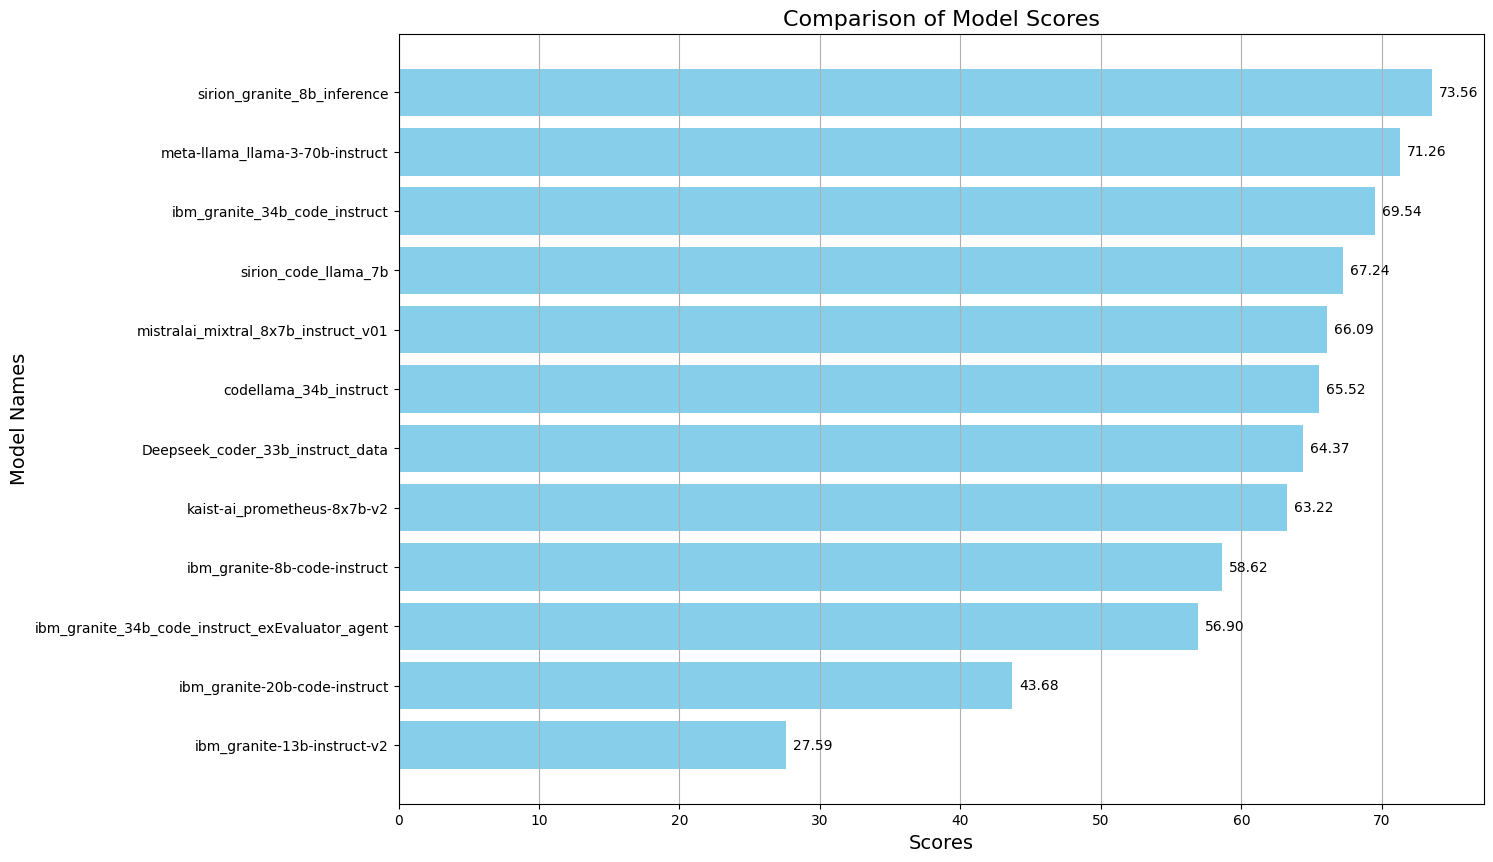

In [44]:
sorted_models = dict(sorted(dict_accuracy_overall.items(), key=lambda item: item[1]))

sorted_model_names = list(sorted_models.keys())
sorted_scores = list(sorted_models.values())

plt.figure(figsize=(14, 10))
bars = plt.barh(sorted_model_names, sorted_scores, color='skyblue')

for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', 
             va='center', ha='left', fontsize=10)

plt.xlabel('Scores', fontsize=14)
plt.ylabel('Model Names', fontsize=14)
plt.title('Comparison of Model Scores', fontsize=16)
plt.grid(axis='x')

plt.show()
